# Unraveling causal structure

The goal of this notebook is to figure out why in some cases random graphs do not generate similar causal structures for the driver-node. 

# ideas
- Monte-carlo samples omhoog gooien voor geteste graaf. 
- Nudge size met netwerk spelen -> hoger contrast
- Identificeerbaarheid met mi. Rank-test of standard error of the mean. 
- 

optimalizatie

In [1]:
# load modules and datasets
%load_ext autoreload
import numpy as np, sys, os, holoviews as hv, scipy, networkx as nx
sys.path.insert(0, '../') # add normal modules
from Utils import IO, plotting as plotz, stats
import matplotlib.pyplot as plt
from matplotlib import style
style.use('seaborn-notebook')


In [2]:
root = '../Data/new24/2019-07-18T15:14:47.056292'
data = IO.DataLoader(root)
data = {os.path.join(root, k): v for k,v in data.items()}
settings = IO.loadSets(data)

  0%|          | 0/1020 [00:00<?, ?it/s]

Extracting data...
Done
Reading settings in ../Data/new24/2019-07-18T15:14:47.056292/2019-07-18T15:14:47.056311: using json
loading graph


100%|██████████| 1020/1020 [00:29<00:00, 55.00it/s]

In [3]:
aucs = {}
params = dict(\
             maxfev = int(1e6),\
             bounds = (0, np.inf), \
             )
func = lambda x, a, b, c, d, e, f, g: a + b * np.exp(- c * (x - d)) + e * np.exp(- f * (x - g))
from tqdm import tqdm_notebook as tqdm
for k, setting in tqdm(settings.items()):
    s = setting.data.shape
    tmp = setting.data.reshape(-1, s[-1])
#     ss = tmp.shape
#     tmp = np.array([np.pad(i, (0, 100), 'linear_ramp', end_values = (0, 0)) for i in tmp])
#     print(tmp.shape, s)
    aucs[k] = stats.aucs(tmp, func, params = params).reshape(s[:-1])

100%|██████████| 1020/1020 [00:40<00:00, 55.00it/s]../Utils/stats.py:12: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  auc[node] = quad(tmp, *bounds)[0]


[[7 7 9 9 7 7 7 7 7 7 7 7 7 7 7 7 7 7 9 7]
 [9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9]
 [7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7]
 [7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7]
 [7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7]
 [2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2]]
[0.15 0.85 0.85 0.85 0.  ]


/home/casper/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


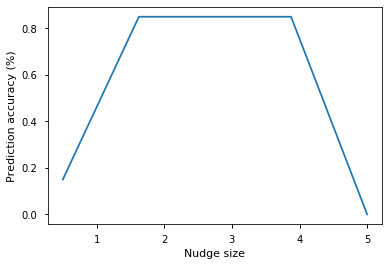

In [4]:
percentages = []
for idx, (k, auc) in enumerate(aucs.items()):
    tmp = auc.squeeze()
    tmp = np.argsort(tmp, axis = -1)
    print(tmp[..., -1])
    y = tmp[0, ..., -1]
    x = np.array([y == i[:, -1] for i in tmp[1:]])
    percentages.append(x)
percentages = np.array(percentages).squeeze()
print(percentages.mean(-1))   


# fig, ax = plt.subplots()
# ax.imshow(percentages.T, aspect = 'auto')
# fig.show()

fig, ax = plt.subplots()
ax.plot(setting.pulseSizes, percentages.mean(-1))
ax.set(xlabel = 'Nudge size', ylabel = 'Prediction accuracy (%)')
fig.show()

<IPython.core.display.Javascript object>


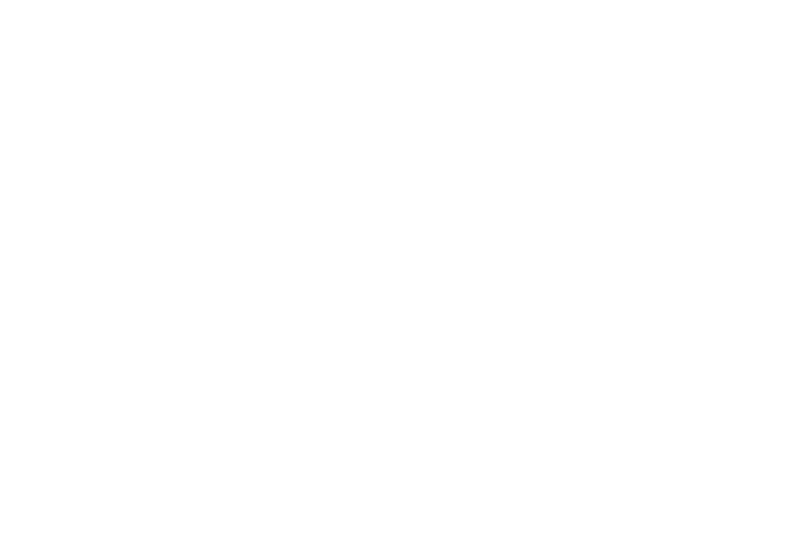

(6, 20, 10, 14)


In [5]:
%matplotlib notebook
fig, ax = plt.subplots()
zdx = 2
for k, setting in settings.items():
    colors = plt.cm.tab20(range(settings[k].nNodes))
    v = setting.data.squeeze()
    print(v.shape)
    for node in range(setting.nNodes):
        if node == 0 :
            zorder = 5
        else:
            zorder = 1
        ax.plot(v[zdx, ..., node, :].T, color = colors[node], label = node, zorder = zorder)
# ax.set(xscale = 'linear', yscale = 'log')
elems = [plt.Line2D([0], [0], color = c, label = idx) for idx, c in enumerate(colors)]
ax.legend(handles = elems)
fig.show()

<IPython.core.display.Javascript object>


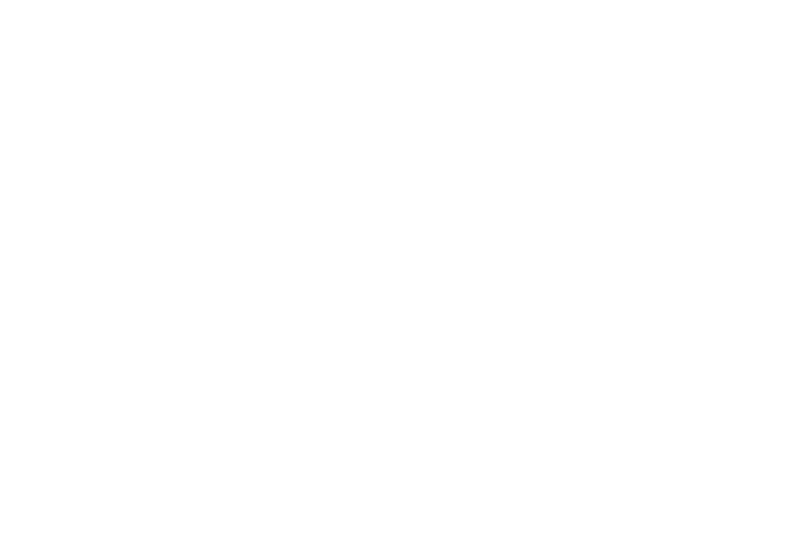

[0.5, 1.625, 2.75, 3.875, 5.0]


In [6]:
import matplotlib.pyplot as plt
II  = 'Informational impact'
LCI = 'Low causal impact'
HCI = 'High causal impact'
fig, ax = plt.subplots()
sets = [0,1]
print(setting.pulseSizes)
for k, v in aucs.items():
    v = v[sets].squeeze()
    colors = plt.cm.tab20(range(settings[k].nNodes))
    for node in range(settings[k].nNodes):
        ax.scatter(*v[...,node], color = colors[node], label = node)
ax.set(xlabel = II, ylabel = LCI)
ax.set_title(f'Nudge = {setting.pulseSizes[sets[-1]-1]}')
# ax.legend()
fig.show()




<IPython.core.display.Javascript object>


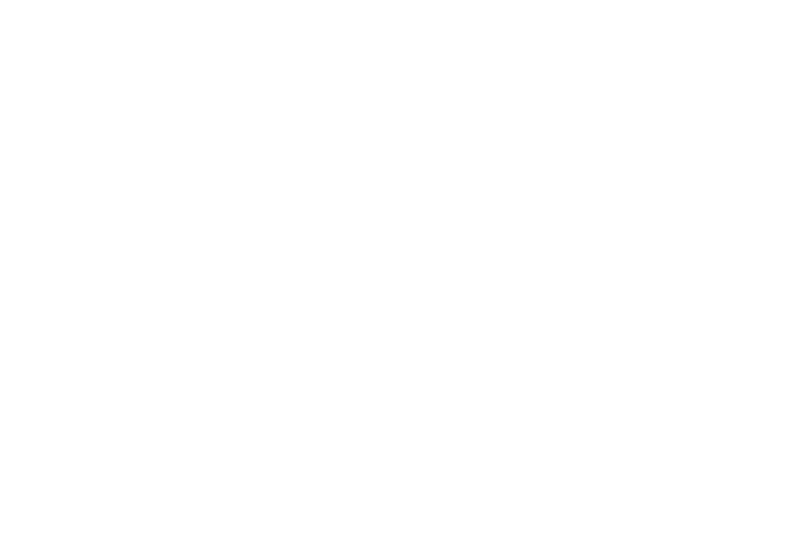

(6, 20, 10)


interactive(children=(IntSlider(value=1, description='nudge', max=5, min=1), Output()), _dom_classes=('widget-…

In [7]:
import ipywidgets as widgets

fig, ax = plt.subplots()
v = np.array([i for i in aucs.values()]).squeeze()
print(v.shape)
nudgeSlider = widgets.IntSlider(min = 1, max = v.shape[0] - 1)
@widgets.interact(\
                 nudge = nudgeSlider)
def update(nudge = 1):
    ax.cla()
    for node in range(setting.nNodes):
        ax.scatter(*v[[0, nudge], ..., node], color = colors[node])
    ax.set_title(f'Nudge = {setting.pulseSizes[nudge - 1]}')
    ax.set(xlabel = 'informational impact', ylabel = 'causal impact')
    fig.canvas.flush_events()
fig.show()


# markers = ('o', 'v', '^', '<', '>', '8', 's', 'p', '*', 'h', 'H', 'D', 'd', 'P', 'X')
#     v = v.squeeze()
#     for nudge in range(v.shape[0] - 1):
#         for node in range(settings[k].nNodes):
#             print(v.shape)
#             ax.scatter(*v[[0, nudge + 1], ..., node], marker = markers[nudge], color = colors[node])
# ax.set(yscale = 'log', xscale = 'log')

(20, 10) (20, 10, 14)


<IPython.core.display.Javascript object>


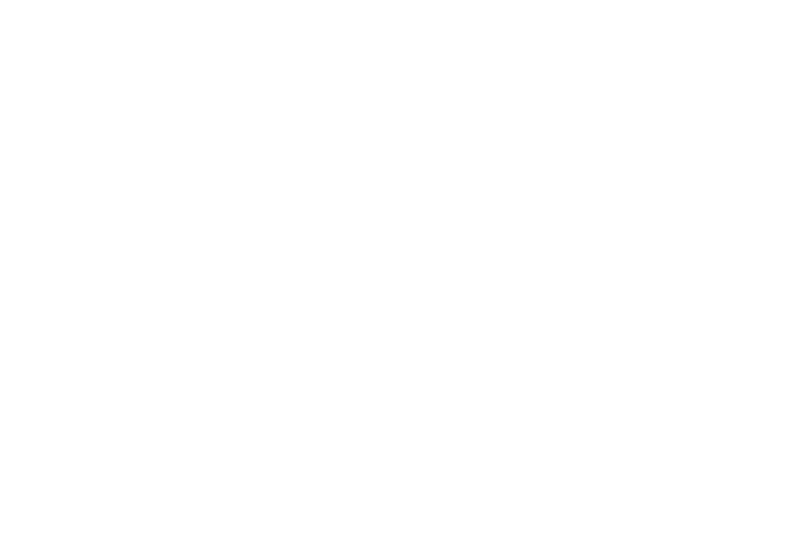

<IPython.core.display.Javascript object>


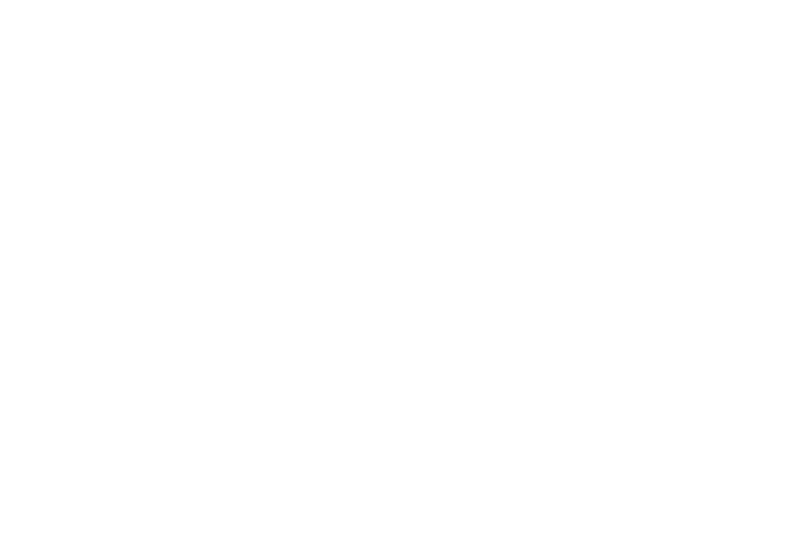

Using circular_layout
()


In [8]:
lci = np.array([i.data[1] for i in settings.values()]).squeeze()
trials, nodes, t = lci.shape

mu = lci.mean(0)
se = lci.std(0) / np.sqrt(trials)
zdx = 5
tmp = lci[..., 1]
print(tmp.shape, lci.shape)
x = np.arange(lci.shape[1])
fig, ax = plt.subplots()
[ax.scatter(x, i, color = c) for i, c in zip(tmp, colors)]
fig.show()

for setting in settings.values():
    fig, ax = plt.subplots()
    g = nx.node_link_graph(setting.graph)
    
    plotz.addGraphPretty(g, ax = ax)
tmp = np.asarray(aucs.values())
print(tmp.shape)

# IO.savePickle('../test_this.pickle', nx.node_link_graph(setting.graph))

# times = []
# for trial in range(trials):
#     for ti in range(t):
#         leader = np.argmax(lci[trial, :, ti])
#         val = lci[trial, leader, ti]
#         if val > mu[t]

(6, 10, 14) (6, 10, 14) (6, 20, 10, 14)
[0.5, 1.625, 2.75, 3.875, 5.0]


<IPython.core.display.Javascript object>


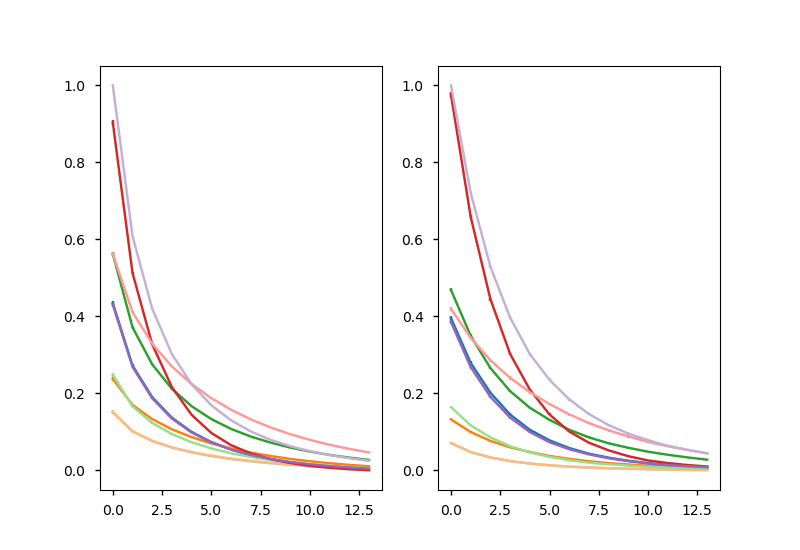

In [13]:
d = np.array([i.data for i in settings.values()]).squeeze()
av = d.mean(1)
er = d.std(1) / np.sqrt(20)
print(av.shape, er.shape, d.shape)
x = np.arange(14)
%matplotlib notebook

print(setting.pulseSizes)
fig, ax = plt.subplots(1, 2)
for idx, c in enumerate(colors):
    for s, axi in zip([0, 1], ax):
        axi.errorbar(x, av[s, idx], yerr = 2 * er[s, idx],  color = c)
#         axi.set(yscale = 'log')
fig.show()


In [12]:
beta = 1/.8
en = lambda x, beta: 1 / (1 + np.exp(-beta * x))
d = lambda x, beta: en(x, beta)  * (1 - en(x, beta))
e = lambda x, beta: -np.log(1/x - 1) / beta
h = lambda x, beta: beta * d(x, beta) * (1 - 2 * en(x, beta))
g = nx.node_link_graph(setting.graph)

print(setting.pulseSizes)
# print(px[0].argsort(0))
# print(px[0].shape)

changes = np.zeros((setting.nNodes, 2))
for i in range(setting.nNodes):
    f =  e(px[0, i, 0], beta)
    changes[i]= (en(f, beta), d(f,beta))
    print(i, d(f, beta), f, g.degree(i))
fig, ax = plt.subplots()
ax.scatter(*changes.T)
ax.set(xlabel = 'energy', ylabel = 'change')
fig.show()


x  = np.linspace(-5, 5)
y = np.linspace(-1, 1, 1000)
fig, ax = plt.subplots()
ax.plot(x, en(x, beta))
ax.plot(x, d(x, beta))
ax.plot(x, h(x, beta))
ax.scatter(e(px[0, :, 0], beta), px[0,:, 0], color = colors)

t
# ax.plot( y, e(y, beta))
fig.show()

#     print(i, g.degree(i), e(px[0, i,0], beta))
print(px[0])


[0.5, 1.625, 2.75, 3.875, 5.0]


NameError: name 'px' is not defined

In [42]:
mi = setting.data[0].squeeze()

from Models.fastIsing import Ising
m = Ising(graph = nx.node_link_graph(setting.graph), updateType = '0.25', magSide = 'neg')

from scipy import optimize
def func(x, a, b, c, d):
    return a / (1 + np.exp(-b * (x - c))) + d

temps = np.linspace(0, 10)
samps = m.matchMagnetization(temps)
coeffs = optimize.curve_fit(func, temps, samps[0])[0]
xr = np.linspace(0, temps.max(), 1000)
x0 = optimize.fsolve(lambda x: abs(func(x, *coeffs) - .5), 1)
samps = m.matchMagnetization(temps)
m.t = x0
 



  0%|          | 0/50 [00:00<?, ?it/s]

  4%|▍         | 2/50 [00:00<00:06,  7.68it/s]

Computing mag per t




 16%|█▌        | 8/50 [00:00<00:02, 20.71it/s]

 16%|█▌        | 8/50 [00:00<00:02, 20.71it/s]

 16%|█▌        | 8/50 [00:00<00:02, 20.71it/s]

 20%|██        | 10/50 [00:00<00:01, 20.71it/s]

 20%|██        | 10/50 [00:00<00:01, 20.71it/s]

 28%|██▊       | 14/50 [00:00<00:02, 15.10it/s]

 28%|██▊       | 14/50 [00:00<00:02, 15.10it/s]

 30%|███       | 15/50 [00:00<00:02, 15.10it/s]

 36%|███▌      | 18/50 [00:00<00:02, 15.10it/s]

 40%|████      | 20/50 [00:00<00:01, 15.61it/s]

 46%|████▌     | 23/50 [00:00<00:02, 12.28it/s]

 50%|█████     | 25/50 [00:00<00:01, 13.73it/s]

 58%|█████▊    | 29/50 [00:00<00:01, 18.20it/s]

 62%|██████▏   | 31/50 [00:00<00:01, 17.01it/s]

 64%|██████▍   | 32/50 [00:00<00:01, 15.46it/s]

 66%|██████▌   | 33/50 [00:00<00:01, 15.46it/s]

 68%|██████▊   | 34/50 [00:01<00:01, 15.46it/s]

 68%|██████▊   | 34/50 [00:01<00:01, 15.46it/s]

 74%|███████▍  | 37/50 [00:01<00:01, 12.94it/s]

 80%|████████  | 40/50 [00:01<00:00, 11.09it/s]

 82%|████████▏ | 41/5

Computing mag per t




 10%|█         | 5/50 [00:00<00:03, 11.26it/s]

 16%|█▌        | 8/50 [00:00<00:01, 21.98it/s]

 16%|█▌        | 8/50 [00:00<00:01, 21.98it/s]

 22%|██▏       | 11/50 [00:00<00:01, 20.61it/s]

 24%|██▍       | 12/50 [00:00<00:01, 20.61it/s]

 28%|██▊       | 14/50 [00:00<00:01, 20.61it/s]

 34%|███▍      | 17/50 [00:00<00:01, 19.01it/s]

 34%|███▍      | 17/50 [00:00<00:01, 19.01it/s]

 44%|████▍     | 22/50 [00:00<00:01, 19.77it/s]

 46%|████▌     | 23/50 [00:00<00:01, 20.49it/s]

 54%|█████▍    | 27/50 [00:00<00:01, 21.86it/s]

 56%|█████▌    | 28/50 [00:00<00:01, 21.86it/s]

 58%|█████▊    | 29/50 [00:00<00:00, 21.86it/s]

 66%|██████▌   | 33/50 [00:01<00:00, 20.42it/s]

 76%|███████▌  | 38/50 [00:01<00:00, 21.69it/s]

 80%|████████  | 40/50 [00:01<00:00, 26.32it/s]

 82%|████████▏ | 41/50 [00:01<00:00, 26.32it/s]

 84%|████████▍ | 42/50 [00:01<00:00, 26.32it/s]

 90%|█████████ | 45/50 [00:01<00:00, 25.39it/s]

100%|██████████| 50/50 [00:01<00:00, 35.58it/s]

<IPython.core.display.Javascript object>


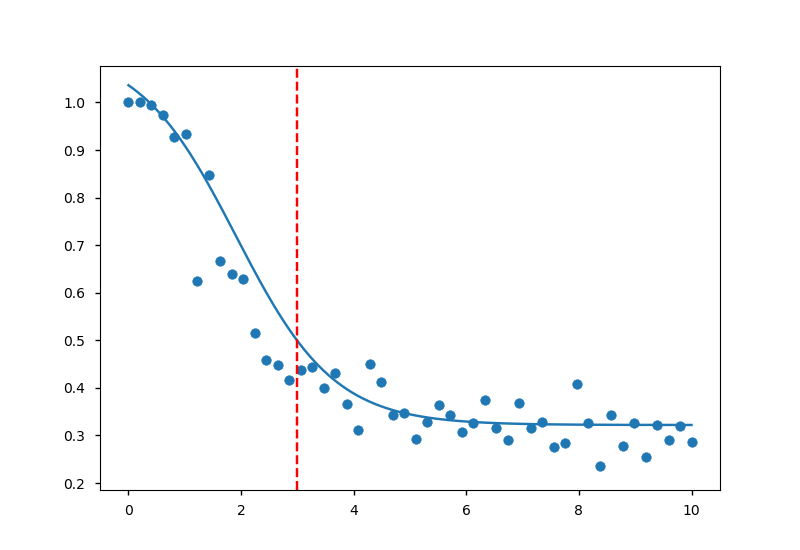

In [43]:
fig, ax = plt.subplots()
ax.scatter(temps,  samps[0])
ax.plot(xr, func(xr, *coeffs))
ax.axvline(x0, color = 'red', linestyle = 'dashed')
fig.show()

In [65]:
m.t = x0

nudges = np.logspace(-2, 1.2, 10)

from Utils.misc import flattenDict

fdata = flattenDict(data)
snapshots = [IO.loadPickle(i).snapshots for i in fdata if '{}' in i]
px        = np.asarray([IO.loadPickle(i).px for i in fdata if '{}' in i])
rsnapshots = {}

print(len(snapshots))
for s in snapshots:
    for k, v in s.items():
        rsnapshots[k] = rsnapshots.get(k, 0) + v / len(snapshots)
rsnapshots = snapshots[0]
from Toolbox import infcy
deltas = 30
repeats = int(1e4)

output = np.zeros((nudges.size, deltas, m.nNodes, m.nStates))
for idx, nudge in enumerate(nudges):
    m.nudges = {'7' : nudge}
    cicpx, cipx, cimi = infcy.runMC(m, rsnapshots, deltas, repeats)
    output[idx] = cipx



  0%|          | 0/212 [00:00<?, ?it/s]

100%|██████████| 212/212 [00:00<00:00, 341340.67it/s]

  0%|          | 0/212 [00:00<?, ?it/s]

20
Decoding..
starting runs




  0%|          | 1/212 [00:00<01:23,  2.51it/s]

  1%|          | 2/212 [00:00<01:11,  2.96it/s]

  4%|▍         | 8/212 [00:00<00:49,  4.13it/s]

  5%|▍         | 10/212 [00:00<00:43,  4.63it/s]

  8%|▊         | 16/212 [00:00<00:30,  6.36it/s]

  9%|▉         | 19/212 [00:01<00:27,  7.03it/s]

  9%|▉         | 20/212 [00:01<00:23,  8.06it/s]

 11%|█▏        | 24/212 [00:01<00:21,  8.85it/s]

 12%|█▏        | 26/212 [00:01<00:20,  8.88it/s]

 15%|█▌        | 32/212 [00:01<00:15, 11.36it/s]

 16%|█▌        | 34/212 [00:02<00:16, 10.63it/s]

 17%|█▋        | 37/212 [00:02<00:13, 12.96it/s]

 19%|█▉        | 40/212 [00:02<00:11, 15.36it/s]

 20%|██        | 43/212 [00:02<00:11, 15.26it/s]

 21%|██        | 45/212 [00:02<00:11, 14.63it/s]

 23%|██▎       | 48/212 [00:02<00:09, 16.58it/s]

 24%|██▎       | 50/212 [00:02<00:09, 16.42it/s]

 24%|██▍       | 51/212 [00:02<00:09, 17.70it/s]

 25%|██▌       | 53/212 [00:03<00:11, 14.07it/s]

 25%|██▌       | 54/212 [00:03<00:11, 14.04it/s]

 

Delta =  12.61 sec
Decoding..
starting runs




  0%|          | 1/212 [00:00<01:27,  2.41it/s]

  3%|▎         | 6/212 [00:00<01:01,  3.36it/s]

  4%|▍         | 9/212 [00:00<00:48,  4.18it/s]

  5%|▌         | 11/212 [00:00<00:37,  5.39it/s]

  7%|▋         | 15/212 [00:01<00:27,  7.23it/s]

  8%|▊         | 18/212 [00:01<00:25,  7.67it/s]

 11%|█         | 23/212 [00:01<00:18, 10.08it/s]

 12%|█▏        | 26/212 [00:01<00:19,  9.47it/s]

 14%|█▎        | 29/212 [00:02<00:17, 10.62it/s]

 14%|█▍        | 30/212 [00:02<00:14, 12.21it/s]

 15%|█▌        | 32/212 [00:02<00:13, 13.42it/s]

 16%|█▌        | 34/212 [00:02<00:12, 14.63it/s]

 17%|█▋        | 35/212 [00:02<00:10, 16.98it/s]

 18%|█▊        | 38/212 [00:02<00:13, 13.12it/s]

 20%|█▉        | 42/212 [00:02<00:11, 14.55it/s]

 20%|█▉        | 42/212 [00:02<00:11, 14.55it/s]

 21%|██        | 44/212 [00:03<00:13, 12.30it/s]

 22%|██▏       | 47/212 [00:03<00:12, 12.77it/s]

 24%|██▎       | 50/212 [00:03<00:10, 14.88it/s]

 25%|██▍       | 52/212 [00:03<00:10, 15.50it/s]

 

Delta =  14.32 sec
Decoding..
starting runs




  0%|          | 1/212 [00:00<01:21,  2.57it/s]

  4%|▍         | 9/212 [00:00<00:58,  3.48it/s]

  6%|▌         | 13/212 [00:00<00:41,  4.78it/s]

  8%|▊         | 16/212 [00:01<00:31,  6.16it/s]

  8%|▊         | 18/212 [00:01<00:29,  6.67it/s]

  9%|▉         | 20/212 [00:01<00:23,  8.17it/s]

 10%|█         | 22/212 [00:01<00:19,  9.77it/s]

 11%|█▏        | 24/212 [00:01<00:16, 11.27it/s]

 12%|█▏        | 26/212 [00:01<00:15, 12.14it/s]

 13%|█▎        | 28/212 [00:01<00:13, 13.35it/s]

 15%|█▍        | 31/212 [00:02<00:11, 15.59it/s]

 16%|█▌        | 33/212 [00:02<00:14, 12.69it/s]

 17%|█▋        | 36/212 [00:02<00:12, 14.60it/s]

 18%|█▊        | 38/212 [00:02<00:11, 15.22it/s]

 19%|█▉        | 40/212 [00:02<00:14, 12.25it/s]

 21%|██        | 44/212 [00:02<00:11, 14.26it/s]

 23%|██▎       | 48/212 [00:03<00:11, 13.85it/s]

 24%|██▍       | 51/212 [00:03<00:10, 15.96it/s]

 25%|██▌       | 53/212 [00:03<00:09, 16.70it/s]

 26%|██▋       | 56/212 [00:03<00:09, 16.60it/s]



Delta =  13.39 sec
Decoding..
starting runs




  1%|          | 2/212 [00:00<01:21,  2.57it/s]

  1%|          | 2/212 [00:00<01:21,  2.57it/s]

  3%|▎         | 7/212 [00:00<00:57,  3.59it/s]

  4%|▍         | 9/212 [00:00<00:49,  4.13it/s]

  5%|▍         | 10/212 [00:00<00:40,  4.98it/s]

  8%|▊         | 16/212 [00:01<00:28,  6.78it/s]

  9%|▉         | 19/212 [00:01<00:25,  7.69it/s]

 11%|█▏        | 24/212 [00:01<00:18, 10.13it/s]

 13%|█▎        | 27/212 [00:01<00:17, 10.42it/s]

 15%|█▍        | 31/212 [00:01<00:13, 13.22it/s]

 16%|█▌        | 34/212 [00:02<00:14, 12.35it/s]

 18%|█▊        | 39/212 [00:02<00:11, 15.44it/s]

 20%|█▉        | 42/212 [00:02<00:12, 14.10it/s]

 22%|██▏       | 47/212 [00:02<00:09, 17.22it/s]

 24%|██▎       | 50/212 [00:02<00:10, 15.22it/s]

 26%|██▌       | 55/212 [00:03<00:08, 18.17it/s]

 28%|██▊       | 59/212 [00:03<00:09, 16.14it/s]

 28%|██▊       | 59/212 [00:03<00:09, 16.14it/s]

 30%|██▉       | 63/212 [00:03<00:08, 17.86it/s]

 31%|███       | 66/212 [00:03<00:09, 15.79it/s]

 3

Delta =  10.98 sec
Decoding..
starting runs




  0%|          | 1/212 [00:00<01:23,  2.54it/s]

  4%|▍         | 9/212 [00:00<00:58,  3.44it/s]

  8%|▊         | 18/212 [00:01<00:32,  6.03it/s]

  9%|▉         | 19/212 [00:01<00:24,  7.81it/s]

  9%|▉         | 20/212 [00:01<00:24,  7.81it/s]

 12%|█▏        | 25/212 [00:01<00:21,  8.85it/s]

 16%|█▌        | 33/212 [00:01<00:16, 10.69it/s]

 19%|█▉        | 41/212 [00:02<00:13, 12.51it/s]

 23%|██▎       | 49/212 [00:02<00:11, 14.20it/s]

 26%|██▋       | 56/212 [00:02<00:08, 18.47it/s]

 28%|██▊       | 60/212 [00:03<00:09, 15.72it/s]

 31%|███       | 65/212 [00:03<00:09, 15.74it/s]

 33%|███▎      | 70/212 [00:03<00:07, 19.73it/s]

 35%|███▍      | 74/212 [00:03<00:07, 17.35it/s]

 37%|███▋      | 78/212 [00:04<00:06, 20.56it/s]

 38%|███▊      | 81/212 [00:04<00:07, 16.56it/s]

 41%|████      | 86/212 [00:04<00:06, 19.81it/s]

 42%|████▏     | 89/212 [00:04<00:07, 16.57it/s]

 44%|████▍     | 94/212 [00:04<00:06, 19.53it/s]

 46%|████▌     | 97/212 [00:05<00:06, 16.75it/s]



Delta =  10.92 sec
Decoding..
starting runs




  1%|          | 2/212 [00:00<01:10,  2.98it/s]

  1%|          | 2/212 [00:00<01:10,  2.98it/s]

  4%|▍         | 9/212 [00:00<00:51,  3.97it/s]

  5%|▍         | 10/212 [00:00<00:38,  5.22it/s]

  8%|▊         | 18/212 [00:01<00:23,  8.28it/s]

  8%|▊         | 18/212 [00:01<00:23,  8.28it/s]

 12%|█▏        | 25/212 [00:01<00:18,  9.87it/s]

 16%|█▌        | 33/212 [00:02<00:15, 11.53it/s]

 16%|█▌        | 34/212 [00:02<00:13, 13.37it/s]

 18%|█▊        | 39/212 [00:02<00:10, 16.68it/s]

 20%|█▉        | 42/212 [00:02<00:12, 14.01it/s]

 22%|██▏       | 47/212 [00:02<00:09, 17.58it/s]

 24%|██▎       | 50/212 [00:02<00:10, 14.78it/s]

 26%|██▌       | 55/212 [00:02<00:08, 17.96it/s]

 27%|██▋       | 58/212 [00:03<00:10, 15.13it/s]

 29%|██▉       | 62/212 [00:03<00:07, 19.60it/s]

 29%|██▉       | 62/212 [00:03<00:07, 19.60it/s]

 31%|███       | 65/212 [00:03<00:08, 16.71it/s]

 33%|███▎      | 69/212 [00:03<00:08, 17.11it/s]

 34%|███▍      | 73/212 [00:04<00:07, 18.35it/s]

 

Delta =  11.21 sec
Decoding..
starting runs




  1%|          | 2/212 [00:00<01:10,  2.97it/s]

  1%|          | 2/212 [00:00<01:10,  2.97it/s]

  4%|▍         | 9/212 [00:00<00:52,  3.85it/s]

  8%|▊         | 17/212 [00:01<00:38,  5.09it/s]

 12%|█▏        | 25/212 [00:01<00:28,  6.55it/s]

 15%|█▍        | 31/212 [00:01<00:20,  8.93it/s]

 16%|█▌        | 34/212 [00:02<00:19,  9.16it/s]

 18%|█▊        | 39/212 [00:02<00:14, 12.03it/s]

 20%|█▉        | 42/212 [00:02<00:14, 11.47it/s]

 22%|██▏       | 47/212 [00:02<00:11, 14.58it/s]

 24%|██▎       | 50/212 [00:02<00:12, 13.25it/s]

 26%|██▌       | 55/212 [00:02<00:09, 16.40it/s]

 27%|██▋       | 58/212 [00:03<00:10, 14.39it/s]

 30%|██▉       | 63/212 [00:03<00:08, 17.68it/s]

 31%|███       | 66/212 [00:03<00:09, 14.99it/s]

 33%|███▎      | 71/212 [00:03<00:07, 18.25it/s]

 35%|███▍      | 74/212 [00:04<00:08, 15.46it/s]

 37%|███▋      | 79/212 [00:04<00:07, 18.51it/s]

 39%|███▊      | 82/212 [00:04<00:08, 15.77it/s]

 41%|████      | 86/212 [00:04<00:07, 17.97it/s]

 

Delta =  10.93 sec
Decoding..
starting runs




  1%|          | 2/212 [00:00<01:10,  2.99it/s]

  3%|▎         | 6/212 [00:00<01:08,  2.99it/s]

  4%|▍         | 9/212 [00:00<00:55,  3.67it/s]

  5%|▍         | 10/212 [00:00<00:44,  4.54it/s]

  8%|▊         | 17/212 [00:01<00:33,  5.77it/s]

  8%|▊         | 18/212 [00:01<00:26,  7.24it/s]

 12%|█▏        | 25/212 [00:01<00:21,  8.83it/s]

 15%|█▌        | 32/212 [00:01<00:15, 11.88it/s]

 17%|█▋        | 35/212 [00:01<00:16, 11.04it/s]

 19%|█▉        | 40/212 [00:02<00:12, 14.25it/s]

 20%|██        | 43/212 [00:02<00:13, 12.84it/s]

 23%|██▎       | 48/212 [00:02<00:10, 15.94it/s]

 24%|██▍       | 51/212 [00:02<00:11, 13.97it/s]

 26%|██▋       | 56/212 [00:02<00:09, 17.11it/s]

 28%|██▊       | 59/212 [00:03<00:10, 14.79it/s]

 30%|███       | 64/212 [00:03<00:08, 17.85it/s]

 32%|███▏      | 67/212 [00:03<00:09, 15.75it/s]

 34%|███▍      | 72/212 [00:03<00:07, 18.44it/s]

 35%|███▌      | 75/212 [00:03<00:08, 16.47it/s]

 37%|███▋      | 78/212 [00:04<00:07, 18.94it/s]

 

Delta =  11.06 sec
Decoding..
starting runs




  1%|          | 2/212 [00:00<01:12,  2.90it/s]

  2%|▏         | 4/212 [00:00<01:11,  2.90it/s]

  4%|▍         | 9/212 [00:00<00:54,  3.69it/s]

  8%|▊         | 16/212 [00:00<00:38,  5.09it/s]

  8%|▊         | 18/212 [00:01<00:33,  5.71it/s]

 10%|█         | 22/212 [00:01<00:24,  7.65it/s]

 12%|█▏        | 25/212 [00:01<00:22,  8.39it/s]

 14%|█▎        | 29/212 [00:01<00:16, 10.78it/s]

 15%|█▌        | 32/212 [00:01<00:14, 12.40it/s]

 17%|█▋        | 35/212 [00:02<00:12, 14.38it/s]

 18%|█▊        | 38/212 [00:02<00:11, 15.30it/s]

 19%|█▉        | 41/212 [00:02<00:11, 15.00it/s]

 21%|██        | 45/212 [00:02<00:10, 16.22it/s]

 22%|██▏       | 47/212 [00:02<00:11, 14.09it/s]

 23%|██▎       | 48/212 [00:02<00:11, 14.50it/s]

 25%|██▍       | 52/212 [00:02<00:09, 16.04it/s]

 25%|██▌       | 54/212 [00:03<00:12, 12.50it/s]

 27%|██▋       | 57/212 [00:03<00:10, 14.86it/s]

 28%|██▊       | 60/212 [00:03<00:09, 15.50it/s]

 29%|██▉       | 62/212 [00:03<00:10, 14.33it/s]

 

Delta =  11.84 sec
Decoding..
starting runs




  0%|          | 1/212 [00:00<01:23,  2.54it/s]

  2%|▏         | 5/212 [00:00<01:09,  2.98it/s]

  5%|▍         | 10/212 [00:00<00:49,  4.10it/s]

  6%|▌         | 13/212 [00:00<00:48,  4.10it/s]

  8%|▊         | 17/212 [00:01<00:38,  5.00it/s]

 12%|█▏        | 25/212 [00:01<00:28,  6.48it/s]

 16%|█▌        | 33/212 [00:01<00:21,  8.15it/s]

 19%|█▉        | 40/212 [00:02<00:15, 11.03it/s]

 20%|██        | 43/212 [00:02<00:16, 10.44it/s]

 23%|██▎       | 48/212 [00:02<00:12, 13.41it/s]

 24%|██▍       | 51/212 [00:02<00:13, 12.34it/s]

 26%|██▋       | 56/212 [00:02<00:10, 15.38it/s]

 28%|██▊       | 59/212 [00:03<00:10, 13.94it/s]

 30%|███       | 64/212 [00:03<00:08, 16.90it/s]

 32%|███▏      | 67/212 [00:03<00:09, 15.20it/s]

 34%|███▍      | 72/212 [00:03<00:07, 17.64it/s]

 35%|███▌      | 75/212 [00:03<00:08, 16.30it/s]

 38%|███▊      | 80/212 [00:04<00:07, 17.72it/s]

 39%|███▉      | 83/212 [00:04<00:07, 17.75it/s]

 42%|████▏     | 88/212 [00:04<00:06, 18.31it/s]



Delta =  11.80 sec


(10, 30, 10) (10, 30) (10, 30, 10, 2) (20, 30, 10, 2)


<IPython.core.display.Javascript object>


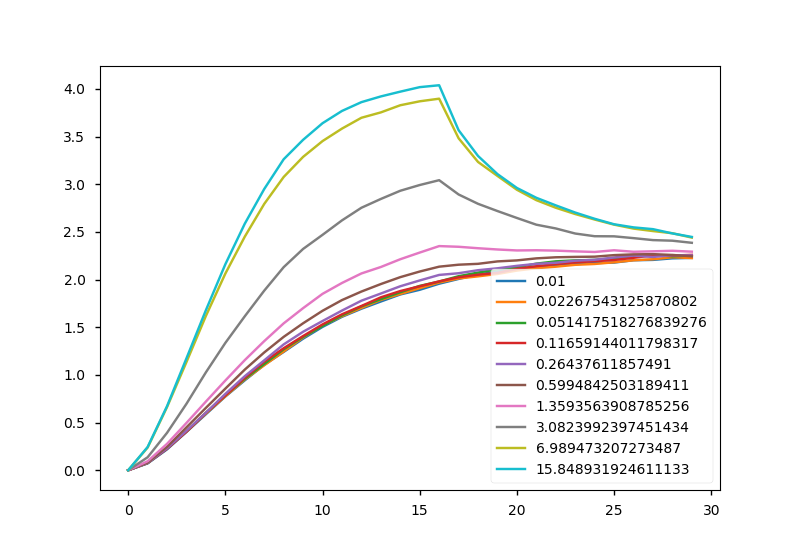

<IPython.core.display.Javascript object>


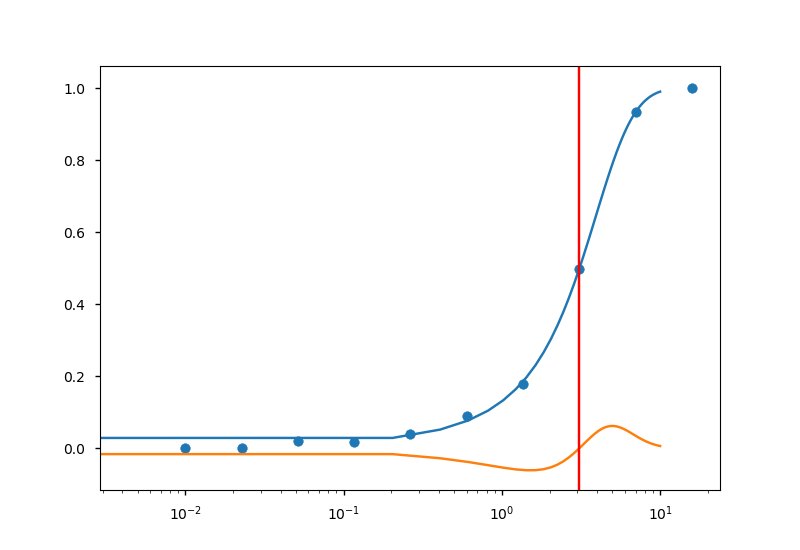

In [86]:
px        = np.asarray([IO.loadPickle(i).px for i in fdata if '{}' in i])
from Utils.stats import KL, JS
d = JS(output, px.mean(0))

e = d.sum(-1)
f = np.trapz(e, axis = -1)

print(d.shape, e.shape, output.shape, px.shape)
fig, ax = plt.subplots()
for idx, i in enumerate(e):
    ax.plot(i, label = nudges[idx])
ax.legend()
fig.show()

f = (f - f.min()) / (f.max() - f.min())
c = optimize.curve_fit(func, nudges, f)
x1 = optimize.fsolve(lambda x: func(x, *c[0]) - .5, 0)


en = lambda x, beta: 1 / (1 + np.exp(-beta * x))
d = lambda x, beta: en(x, beta)  * (1 - en(x, beta))
e = lambda x, beta: -np.log(1/x - 1) / beta
h = lambda x, beta: beta * d(x, beta) * (1 - 2 * en(x, beta))
hh = lambda x: c[0][1] * func(x, *c[0]) * ( 1 - func(x, *c[0])) * (1 - 2 * func(x, *c[0]))
fig, ax = plt.subplots()
ax.scatter(nudges, f)
xr = np.linspace(0, 10)
ax.plot(xr, func(xr, *c[0]))
ax.plot(xr, hh(xr))
ax.axvline(x1, color = 'red')
ax.set(xscale = 'log', yscale = 'linear')
fig.show()

<IPython.core.display.Javascript object>


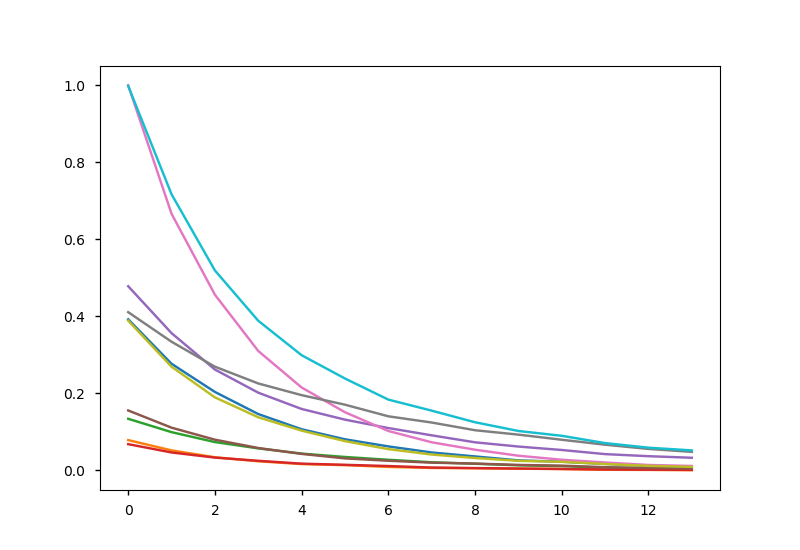

In [64]:
h = setting.data[1].squeeze()
fig, ax = plt.subplots()
ax.plot(h[0].T)